# Case 1. Template
**Neural Networks for Machine Learning Applications**<br>
20.01.2022<br>
G10 Lauri.M & Jesse.J<br>
Metropolia University of Applied Sciences

## 1. Introduction

This report shows stuff

## 2. Setup

The following libraries and functions were used

In [44]:
%pylab inline
import time
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, losses, metrics, optimizers
from sklearn.utils import resample

print(f'tensorflow version: {tf.__version__}')
print(f'pandas version: {pd.__version__}')
print(f'seaborn version: {sns.__version__}')

Populating the interactive namespace from numpy and matplotlib
tensorflow version: 2.7.0
pandas version: 1.3.5
seaborn version: 0.11.2


C:\ProgramData\Anaconda3\envs\Anaconda ML\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['cm']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 3. Dataset

In [91]:
file = "http://users.metropolia.fi/~jessejy/NeuralNetwork/heart_disease_health_indicators_BRFSS2015.csv"
data = pd.read_csv(file, na_values = '?', on_bad_lines='skip')

In [92]:
df = data
holder = pd.DataFrame(tf.one_hot(df['Diabetes'], 3).numpy(), columns = ['no Diab', 'type1 Diab', 'type2 Diab'])
del df['Diabetes']
df.merge(holder, right_index=True)
df.tail()

MergeError: Must pass left_on or left_index=True

## 4. Preprocessing

In [47]:
# Balancing the data

df_majority = df[df['HeartDiseaseorAttack'] == 0.0]
df_minority = df[df['HeartDiseaseorAttack'] == 1.0]
print(df_majority.shape)

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=24000,    # to match average class
                                 random_state=42) # reproducible results

# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                 replace=False,    # sample without replacement
                                 n_samples=24000,     # to match average class
                                 random_state=42) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority_downsampled, df_minority_upsampled])
print(df_upsampled['HeartDiseaseorAttack'].value_counts())

#Define the dependent variable that needs to be predicted (labels)

labels = df_upsampled['HeartDiseaseorAttack']
features = df_upsampled.drop('HeartDiseaseorAttack', axis = 1)
features.fillna(0, inplace = True)

(229787, 22)
0.0    24000
1.0    24000
Name: HeartDiseaseorAttack, dtype: int64


In [48]:
from numpy import shape


labels = 1.0*(labels > 0)
# 70 15 15 trait test validation split, test val split done later
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.3, random_state=1)
shape(train_features), shape(test_features)

((33600, 21), (14400, 21))

## 5. Modeling

In [49]:
from keras import regularizers

normalize = layers.Normalization()
normalize.adapt(train_features)

def make_model():
    model = models.Sequential([
        normalize,
        layers.Dense(21, activation = 'relu',input_shape=(21,1)),
        layers.Dropout(0.2),
        layers.Dense(21, activation = 'relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation = 'sigmoid')
    ])

    model.compile(
        optimizer = optimizers.RMSprop(),
        loss = losses.BinaryCrossentropy(),
        metrics = metrics.BinaryAccuracy(name = 'acc')
    )

    return model

model = make_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 21)               43        
 ion)                                                            
                                                                 
 dense_11 (Dense)            (None, 21)                462       
                                                                 
 dropout_8 (Dropout)         (None, 21)                0         
                                                                 
 dense_12 (Dense)            (None, 21)                462       
                                                                 
 dropout_9 (Dropout)         (None, 21)                0         
                                                                 
 dense_13 (Dense)            (None, 1)                 22        
                                                      

## 6. Training

In [50]:
EPOCHS = 20

t0 = time.time()
r = model.fit(
    train_features,
    train_labels,
    validation_split=0.5,
    epochs = EPOCHS,
    batch_size = 128,
    verbose = 0,
    )

t1 = time.time()
etime = t1 - t0
print(f'Total elapsed time {etime:.2f} s and {etime/EPOCHS:.3f} s/epoch')

Total elapsed time 11.86 s and 0.593 s/epoch


## 7. Performance and evaluation

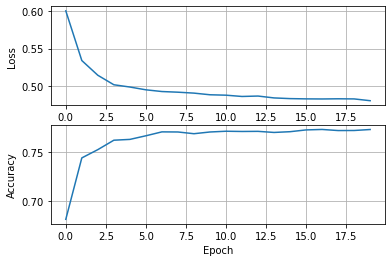

In [51]:
from matplotlib.pyplot import subplot, plot, grid, ylabel, xlabel, show

epochs = r.epoch
loss = r.history['loss']
acc = r.history['acc']

subplot(2, 1, 1)
plot(epochs, loss)
grid()
ylabel('Loss')

subplot(2, 1, 2)
plot(epochs, acc)
grid()
ylabel('Accuracy')
xlabel('Epoch')
show()

## 8. Discussion and conclusions

In [52]:
print(f'Training loss = {loss[-1]:.3f}')
print(f'Training accuracy = {acc[-1]:.3f}')

Training loss = 0.480
Training accuracy = 0.774


In [53]:
predictions = model.predict(train_features)
pred_labels = 1.0*(predictions >= 0.5)
cm = confusion_matrix(train_labels, pred_labels)
print(cm)

[[12368  4402]
 [ 3029 13801]]


<AxesSubplot:>

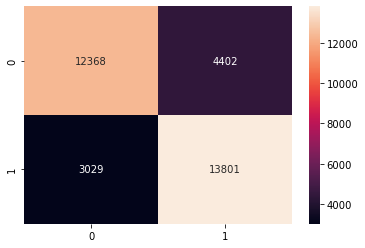

In [59]:
cm = confusion_matrix(train_labels, pred_labels)
sns.heatmap(cm, annot=True, fmt='.0f')

In [55]:
cr = classification_report(train_labels, pred_labels, target_names = ['Healthy', 'Disease'])
print(cr)

              precision    recall  f1-score   support

     Healthy       0.80      0.74      0.77     16770
     Disease       0.76      0.82      0.79     16830

    accuracy                           0.78     33600
   macro avg       0.78      0.78      0.78     33600
weighted avg       0.78      0.78      0.78     33600



In [60]:
tn, fp, fn, tp = confusion_matrix(train_labels, pred_labels).ravel()
print(f'Precision for Healthy = {tn/(tn+fn):.2f}')
print(f'Precision for Disease = {tp/(fp+tp):.2f}')

Precision for Healthy = 0.80
Precision for Disease = 0.76


Our model works fairly well with the precision being in the 81%/71% ballpark.